In [1]:
from __future__ import print_function, division
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, utils
import os
import time
import copy

In [2]:
plt.ion()   # interactive mode
print(torch.cuda.is_available())

False


# Load Data and preprocessing

In [3]:
ROOT_DIR = './data/Caltech256/256_ObjectCategories'
ClassList = os.listdir(ROOT_DIR)
ClassDic = {int(item.split(".")[0]) - 1:item   for item in ClassList }
CLASSNUMBER = len(ClassList)
BATCH_SIZE = 64

In [4]:
class Caltech256Dataset(Dataset):
    """Caltech 256 dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file (filepath, label).
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.imagelist = pd.read_csv(csv_file,usecols=['image','label'])
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.imagelist)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.imagelist.iloc[idx, 0]).replace('\\', '/')
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = int(self.imagelist.iloc[idx, 1].split(".")[0]) - 1
#         label = self.imagelist.iloc[idx, 1]
#         # oneHot the label: label(001.name-257.name)
#         target = self.oneHotLabel(label)
        return image,label #,target
    
#     def oneHotLabel(self,label):
#         targetId = int(label.split(".")[0]) - 1
#         targetnp = np.zeros(CLASSNUMBER)
#         targetnp[targetId] = 1
#         target = torch.as_tensor(targetnp)
#         return target

In [5]:
train_MEAN = [0.55517198, 0.53375827, 0.50551041]
train_STD = [0.23612623, 0.23623358, 0.23891582]
traindata_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = train_MEAN, 
                             std = train_STD)
    ])

caltech256_traindataset = Caltech256Dataset(csv_file='./data/Caltech256/trainDataSet.csv',
                                            root_dir=ROOT_DIR,
                                            transform=traindata_transform)

In [6]:
test_MEAN = [0.5517131 , 0.53087857, 0.50269934]
test_STD = [0.23537882, 0.23507463, 0.23890983]
testdata_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = test_MEAN, 
                             std = test_STD)
    ])

caltech256_testdataset = Caltech256Dataset(csv_file='./data/Caltech256/testDataSet.csv',
                                            root_dir=ROOT_DIR,
                                            transform=testdata_transform)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=caltech256_traindataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=0)

In [8]:
test_loader = torch.utils.data.DataLoader(dataset=caltech256_testdataset,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=0)

In [9]:
dataloaders = {'train': train_loader, 'val': test_loader}
dataset_sizes = {'train': len(caltech256_traindataset), 
                 'val': len(caltech256_testdataset)}

In [10]:
classlist = os.listdir(ROOT_DIR)
classdic = {item : int(item.split(".")[0])-1 for item in classlist }

In [11]:
device = torch.device("cpu")#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check the image after data preprocessing and data augumentation

In [12]:
def show_images(images,labels,predict=False):
    batch_size=len(images)
    im_size = images.size(2)
    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    title=[ClassDic[x] for x in labels.numpy()]
    print('The labels : ',title)
    if predict is False:
        strtitle= ';    '.join(title)
        plt.title(strtitle)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The labels :  ['073.fireworks', '061.dumb-bell', '028.camel']


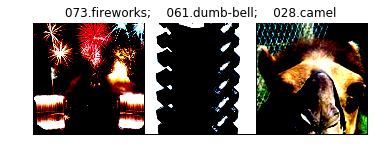

In [13]:
for i, (images,labels) in enumerate(dataloaders['train']):
#     print(i,images.size(),labels.size())
    images=images[0:3,:,:,:]
    labels=labels[0:3]
#     print(i,images.size(),labels.size())

    if i ==0:
        #print(labels)
        plt.figure()
        show_images(images,labels)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

# Define Train function

In [14]:
def train_model(model, pretrained_parameters, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        if(epoch==0 or (epoch+1)%100 == 0):
            print('Epoch {}/{}'.format(epoch+1, num_epochs))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, targets)
                    if phase == 'train':
                        #----------- begin regulisation ----------
                        ''' L2-SP '''
                        alpha = 0.1
                        beta = 0.01
                        reg_loss = 0
                        params_index = -1
                        for params in model.parameters():
                            params_index += 1
                            if params.size() == pretrained_parameters[params_index].size():
                                # parts that share the archetecture
                                delta_param = params - pretrained_parameters[params_index]
                                reg_loss += 0.5* alpha * delta_param.norm(2)**2
                            else: #parts that differ
                                reg_loss += 0.5* beta * params.norm(2)**2
                        loss += reg_loss
                        #----------- end before backward ----------
                        # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == targets.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if(epoch==0 or (epoch+1)%100 == 0):
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
                time_since = time.time() - since
                time_last = (num_epochs-(epoch+1)) * time_since/(epoch+1)
                print('Training has running for{:.0f}m,\
                      will finish in {:.0f}m.'.format(
                    time_since//60, time_last//60, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Fine tuning the ResNet

In [15]:
model_ft = torchvision.models.resnet18(pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [16]:
pretrained_params = [param for param in model_ft.parameters()]
num_ftrs = model_ft.fc.in_features
num_classes = CLASSNUMBER
model_ft.fc = torch.nn.Linear(num_ftrs, num_classes)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [17]:
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)# The initial learning rates are 0.005, 0.01 or 0.02, depending on the tasks.
# We run 9000 iterations and divide the learning rate by 10 after 6000 iterations.!!!

# Decay LR by a factor of 0.1 after 6000 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=6000, gamma=0.1)

# Train

In [18]:
model_ft = train_model(model_ft, pretrained_params, criterion, optimizer_ft, 
                       exp_lr_scheduler, num_epochs=9000)

Epoch 1/9000
----------
train Loss: 5.4407 Acc: 0.3288
Training has running for35m,                      will finish in 315471m.
val Loss: 1.9701 Acc: 0.5872
Training has running for45m,                      will finish in 408203m.



KeyboardInterrupt: 

# visualization

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(test_MEAN)
    std = np.array(test_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(ClassDic[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft)
plt.ioff()
plt.show()